<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: Create tf.data.Datasets for Training and Evaluation
- **[Task 5]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[Task 6]()**: Tokenize and Preprocess Text for BERT
- **[Task 7]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[Task 8]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[Task 9]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[Task 10]()**: Fine-Tune BERT for Text Classification
- **[Task 11]()**: Evaluate the BERT Text Classification Model

In [ ]:
!nvidia-smi

Thu Oct 15 11:00:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    41W / 250W |   8587MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [ ]:
!pip install -q tensorflow==2.3.0

ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
# installing requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# restarting the runtime afterwards

ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


## Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                   compression = 'zip',
                   low_memory = False)
data.shape

(1306122, 3)

In [ ]:
data.head(20)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


<AxesSubplot:title={'center':'Distribution'}, ylabel='Frequency'>

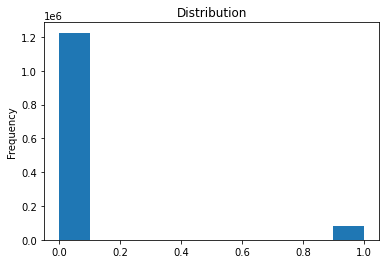

In [ ]:
data.target.plot(kind ='hist', title = "Distribution")

##  Create tf.data.Datasets for Training and Evaluation

In [ ]:
train_data, extra_data = train_test_split(data, random_state = 42, train_size = 0.0075, stratify = data.target.values)
valid_data , _= train_test_split(extra_data, random_state = 42, train_size = 0.00075, stratify = extra_data.target.values)

train_data.shape, valid_data.shape


((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_data['question_text'].values, train_data['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_data['question_text'].values, valid_data['target'].values))

  for text, target in train_data.take(1):
    print(text)
    print(target)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 # Label categories
label_list = [0, 1] 
 # maximum length of (token) input sequences
max_len = 128
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [ ]:
tokenizer.wordpiece_tokenizer.tokenize("hi, how are you?")

['hi', '##,', 'how', 'are', 'you', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, how are you?"))

[7632, 29623, 2129, 2024, 2017, 29632]

##  Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_len, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

We have  to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So we can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

##  Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_len])
  input_mask.set_shape([max_len])
  segment_ids.set_shape([max_len])
  label_id.set_shape([])
  
  x = {
      'input_word_ids':input_ids,
       'input_mask': input_mask,
       'input_type_ids':segment_ids
  }

  return (x, label_id)

##  Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

##  Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids= tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name = 'output')(drop)

  model = tf.keras.Model(
      inputs ={
          'input_word_ids':input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output)
  return model
  
  

##  Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

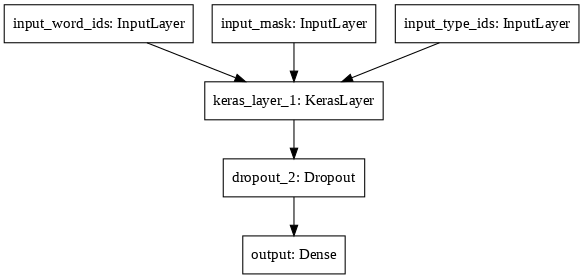

In [ ]:
tf.keras.utils.plot_model(model =model, dpi=76)

In [ ]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data =valid_data,
                    epochs=epochs,
                    verbose= 1)

Epoch 1/4
306/306 [==============================] - ETA: 0s - loss: 0.1730 - binary_accuracy: 0.9372WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_test_batch_end` time: 0.1345s). Check your callbacks.


306/306 [==============================] - 148s 484ms/step - loss: 0.1730 - binary_accuracy: 0.9372 - val_loss: 0.1234 - val_binary_accuracy: 0.9552
Epoch 2/4
306/306 [==============================] - 147s 481ms/step - loss: 0.0978 - binary_accuracy: 0.9619 - val_loss: 0.1497 - val_binary_accuracy: 0.9604
Epoch 3/4
306/306 [==============================] - 147s 481ms/step - loss: 0.0490 - binary_accuracy: 0.9830 - val_loss: 0.1967 - val_binary_accuracy: 0.9583
Epoch 4/4
306/306 [==============================] - 147s 481ms/step - loss: 0.0250 - binary_accuracy: 0.9911 - val_loss: 0.2325 - val_binary_accuracy: 0.9500


##  Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

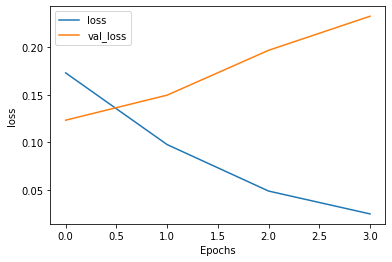

In [ ]:
plot_graphs(history, 'loss')

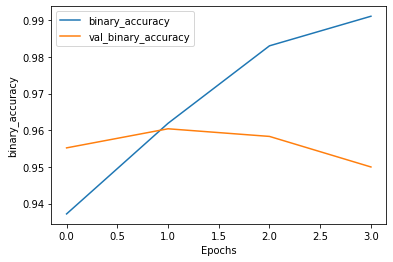

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
sample_example = ["may i take this glass of water", "things are very bad here"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.6
output= ['Insincere' if pred>=threshold  else 'Sincere' for pred in preds]
output

['Sincere', 'Sincere']